In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

## Define FCN16s model for deconvolution layers

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

##############################
#           U-NET
##############################

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [  nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
                    nn.InstanceNorm2d(out_size),
                    nn.ReLU(inplace=True)]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)


        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [6]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [7]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [8]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [9]:
batch_size = 12
epochs     = 25  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 12
gamma      = 0.5
n_class = 4
model_use = "fcn_crop_unet"

## Define path, directory trainning environment

In [10]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/subt_all")
if not os.path.exists(data_dir):
    print("Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

#vgg_model = VGGNet(requires_grad=True, remove_fc=True)
#fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
fcn_model = GeneratorUNet(in_channels=3, out_channels=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    #vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    #fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 1.7779228687286377


In [11]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h_, w_      = 256, 256
val_h     = h_
val_w     = w_

class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.obj_class = ['bb_extinguisher', 'bb_drill', 'bb_backpack']
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # IMAGE
        img_name   = self.data.iloc[idx, 0]
        img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        
        # MASK
        label_name = self.data.iloc[idx, 1]
        label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        #label[label!=0] = 1
        
        # ANNOTATION
        all_l = len(img_name)
        start_l = len(img_name.split('/')[0])
        end_l = all_l - len(img_name.split('.')[-1])
        ann_path = 'Annotations' + img_name[start_l:end_l] + 'xml'
        ann_path = os.path.join(data_dir, ann_path)
        
        # img[y: y + h, x: x + w]
        bbx = self.get_ann(ann_path) # [xmin, ymin, xmax, ymax]
        img = img[bbx[1]:bbx[3], bbx[0]:bbx[2]]
        label = label[bbx[1]:bbx[3], bbx[0]:bbx[2]]
        
        
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)
            
        img = cv2.resize(img, (h_, w_), interpolation=cv2.INTER_CUBIC)
        label = cv2.resize(label, (h_, w_), interpolation=cv2.INTER_CUBIC)
        
        origin_img = img
        
        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        for i in range(self.n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample
    
    def get_ann(self, ann_path):
        target = ET.parse(ann_path).getroot()
        res = []
        for obj in target.iter('object'):
            name = obj.find('name').text.lower().strip()
            if name not in self.obj_class:
                continue
            bbox = obj.find('bndbox')
            if bbox is not None:
                pts = ['xmin', 'ymin', 'xmax', 'ymax']
                bndbox = []
                for i, pt in enumerate(pts):
                    cur_pt = int(bbox.find(pt).text) - 1
                    # scale height or width
                    #cur_pt = cur_pt / width if i % 2 == 0 else cur_pt / height
                    bndbox.append(cur_pt)
                res += [bndbox]  # [xmin, ymin, xmax, ymax]
            else: # For LabelMe tool
                polygons = obj.find('polygon')
                x = []
                y = []
                bndbox = []
                for polygon in polygons.iter('pt'):
                    # scale height or width
                    x.append(int(polygon.find('x').text))
                    y.append(int(polygon.find('y').text))
                bndbox.append(min(x))
                bndbox.append(min(y))
                bndbox.append(max(x))
                bndbox.append(max(y))
                res += [bndbox] # [xmin, ymin, xmax, ymax]
        return res[0]

## Define dataloader and optimizer

In [12]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train.csv")
val_file   = os.path.join(data_dir, "test.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

In [13]:
len(dataiter)

377

## Train

In [14]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_batch{}_epoch{}_RMSprop_lr{}"\
            .format(batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 4 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [15]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [13]:
train()

/home/arg_ws3/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch1, iter0, loss: 0.7037994265556335
epoch1, iter10, loss: 0.5093933939933777
epoch1, iter20, loss: 0.48684439063072205
epoch1, iter30, loss: 0.4882901608943939
epoch1, iter40, loss: 0.4830319881439209
epoch1, iter50, loss: 0.46710026264190674
epoch1, iter60, loss: 0.4547155499458313
epoch1, iter70, loss: 0.4311858117580414
epoch1, iter80, loss: 0.4281863868236542
epoch1, iter90, loss: 0.4210485816001892
epoch1, iter100, loss: 0.4550069272518158
epoch1, iter110, loss: 0.404029905796051
epoch1, iter120, loss: 0.3969467878341675
epoch1, iter130, loss: 0.38693761825561523
epoch1, iter140, loss: 0.39384159445762634
epoch1, iter150, loss: 0.4306701123714447
epoch1, iter160, loss: 0.3776876926422119
epoch1, iter170, loss: 0.3801819980144501
epoch1, iter180, loss: 0.37849658727645874
epoch1, iter190, loss: 0.36623847484588623
epoch1, iter200, loss: 0.3845260739326477
epoch1, iter210, loss: 0.36761951446533203
epoch1, iter220, loss: 0.363866925239563
epoch1, iter230, loss: 0.361288249492645

epoch6, iter160, loss: 0.3815292716026306
epoch6, iter170, loss: 0.3388523459434509
epoch6, iter180, loss: 0.34170204401016235
epoch6, iter190, loss: 0.3403570055961609
epoch6, iter200, loss: 0.339348167181015
epoch6, iter210, loss: 0.3398939073085785
epoch6, iter220, loss: 0.34473830461502075
epoch6, iter230, loss: 0.34193915128707886
epoch6, iter240, loss: 0.3407641351222992
epoch6, iter250, loss: 0.33623284101486206
epoch6, iter260, loss: 0.339343398809433
epoch6, iter270, loss: 0.34184616804122925
epoch6, iter280, loss: 0.3538833558559418
Finish epoch 5, time elapsed 78.20110368728638
epoch5, pix_acc: 0.9390314643515832, meanIoU: 0.8919050278481061, IoUs: [0.86314014 0.85391573 0.95865921], recall: [0.90357153 0.93000814 0.98336442], precision: [0.95071388 0.91256168 0.9744627 ], fscore: [0.92654344 0.92120232 0.97889332]
epoch7, iter0, loss: 0.3418080508708954
epoch7, iter10, loss: 0.34299883246421814
epoch7, iter20, loss: 0.34165501594543457
epoch7, iter30, loss: 0.34124201536178

epoch12, iter0, loss: 0.3454775810241699
epoch12, iter10, loss: 0.3402494788169861
epoch12, iter20, loss: 0.33962374925613403
epoch12, iter30, loss: 0.3348890244960785
epoch12, iter40, loss: 0.3386916518211365
epoch12, iter50, loss: 0.33640092611312866
epoch12, iter60, loss: 0.33462589979171753
epoch12, iter70, loss: 0.3381745219230652
epoch12, iter80, loss: 0.3367338180541992
epoch12, iter90, loss: 0.3345579504966736
epoch12, iter100, loss: 0.34415358304977417
epoch12, iter110, loss: 0.33849915862083435
epoch12, iter120, loss: 0.3369908034801483
epoch12, iter130, loss: 0.3355794847011566
epoch12, iter140, loss: 0.33729276061058044
epoch12, iter150, loss: 0.34381747245788574
epoch12, iter160, loss: 0.3354427218437195
epoch12, iter170, loss: 0.33982786536216736
epoch12, iter180, loss: 0.3394504487514496
epoch12, iter190, loss: 0.33768224716186523
epoch12, iter200, loss: 0.3404909074306488
epoch12, iter210, loss: 0.3436863422393799
epoch12, iter220, loss: 0.3402629792690277
epoch12, iter

epoch17, iter120, loss: 0.3377034366130829
epoch17, iter130, loss: 0.33242350816726685
epoch17, iter140, loss: 0.335184782743454
epoch17, iter150, loss: 0.33705878257751465
epoch17, iter160, loss: 0.33978113532066345
epoch17, iter170, loss: 0.3380733132362366
epoch17, iter180, loss: 0.3306465744972229
epoch17, iter190, loss: 0.3339916169643402
epoch17, iter200, loss: 0.3369491994380951
epoch17, iter210, loss: 0.33527490496635437
epoch17, iter220, loss: 0.3361803889274597
epoch17, iter230, loss: 0.3352912664413452
epoch17, iter240, loss: 0.3326573967933655
epoch17, iter250, loss: 0.3367031514644623
epoch17, iter260, loss: 0.3436187207698822
epoch17, iter270, loss: 0.33653539419174194
epoch17, iter280, loss: 0.33760493993759155
Finish epoch 16, time elapsed 79.79750156402588
epoch16, pix_acc: 0.9481444826809101, meanIoU: 0.9058404445929641, IoUs: [0.87965994 0.87483009 0.96303131], recall: [0.905555   0.93499074 0.98589995], precision: [0.96851571 0.93148915 0.97648037], fscore: [0.93597

epoch22, iter240, loss: 0.33617255091667175
epoch22, iter250, loss: 0.3333977162837982
epoch22, iter260, loss: 0.3330934941768646
epoch22, iter270, loss: 0.33686381578445435
epoch22, iter280, loss: 0.33347925543785095
Finish epoch 21, time elapsed 79.46349024772644
epoch21, pix_acc: 0.94907336652437, meanIoU: 0.9073379202020161, IoUs: [0.88131238 0.87651527 0.96418611], recall: [0.91096378 0.94329482 0.98537148], precision: [0.96438249 0.9252684  0.9781879 ], fscore: [0.93691233 0.93419466 0.98176655]
epoch23, iter0, loss: 0.3334319293498993
epoch23, iter10, loss: 0.33447641134262085
epoch23, iter20, loss: 0.33444321155548096
epoch23, iter30, loss: 0.33207830786705017
epoch23, iter40, loss: 0.3330429792404175
epoch23, iter50, loss: 0.32944923639297485
epoch23, iter60, loss: 0.3364095687866211
epoch23, iter70, loss: 0.3338880240917206
epoch23, iter80, loss: 0.3371255397796631
epoch23, iter90, loss: 0.3348720967769623
epoch23, iter100, loss: 0.33675703406333923
epoch23, iter110, loss: 0.

## Prediction Result

In [14]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    #print(img.shape, inputs.shape)
    #print(inputs[0])
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

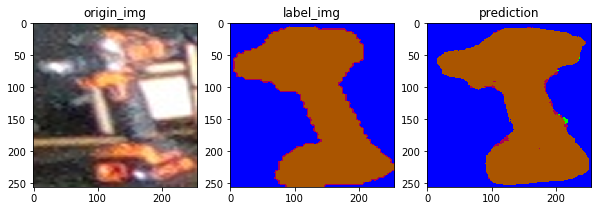

In [19]:
prediction("FCNs_batch12_epoch0_RMSprop_lr0.0001.pkl")